In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

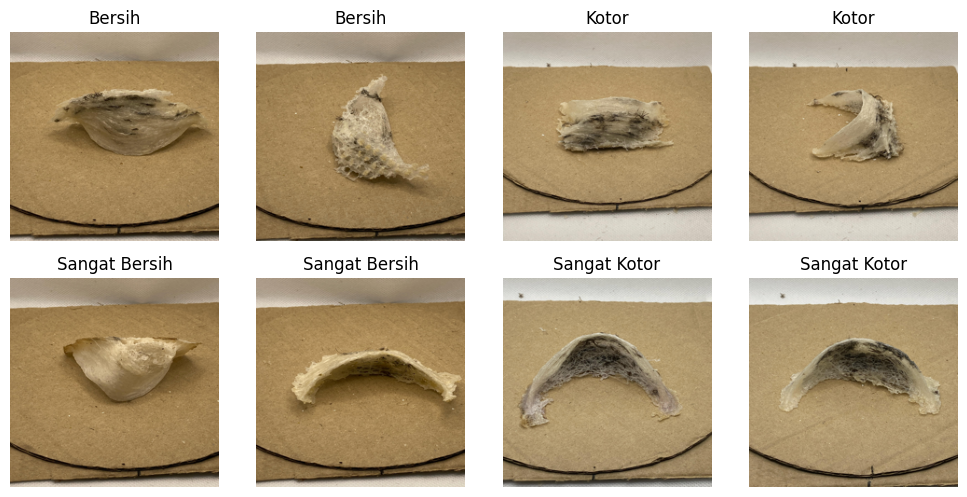

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_images_from_path(directory, target_size=(224, 224), num_images=8):
    # Nama kelas yang sesuai
    class_labels = {
        'SBW_K': 'Kotor',
        'SBW_B': 'Bersih',
        'SBW_SK': 'Sangat Kotor',
        'SBW_SB': 'Sangat Bersih'
    }
    
    # Mengambil semua subfolder kelas
    class_folders = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isdir(os.path.join(directory, fname))]
    
    # Menyiapkan list untuk menyimpan gambar yang akan ditampilkan
    image_paths = []
    
    # Memilih gambar secara acak dari setiap subfolder kelas
    for class_folder in class_folders:
        # Mengambil semua gambar dari subfolder kelas
        image_files = [os.path.join(class_folder, fname) for fname in os.listdir(class_folder) if fname.endswith(('jpg', 'jpeg', 'png'))]
        
        # Jika ada gambar, pilih lebih dari satu gambar acak
        if image_files:
            num_images_from_class = min(len(image_files), num_images // len(class_folders))  # Membatasi gambar per kelas
            selected_images = random.sample(image_files, num_images_from_class)  # Memilih gambar secara acak
            image_paths.extend(selected_images)  # Menambahkan gambar yang dipilih ke list image_paths
    
    # Jika jumlah gambar kurang dari num_images, tambahkan gambar acak dari semua kelas
    if len(image_paths) < num_images:
        additional_images_needed = num_images - len(image_paths)
        additional_images = random.sample(image_paths, additional_images_needed)
        image_paths.extend(additional_images)
    
    # Menampilkan gambar
    plt.figure(figsize=(10, 10))  # Ukuran figure menyesuaikan jumlah gambar

    for i, img_path in enumerate(image_paths[:num_images]):  # Menampilkan gambar sebanyak num_images
        img = Image.open(img_path)
        img = img.resize(target_size)  # Resize gambar agar konsisten ukuran
        img_array = np.array(img) / 255.0  # Normalisasi agar sama seperti generator
        
        # Mendapatkan nama folder kelas (misalnya 'SBW_K', 'SBW_B', dll.)
        class_name = os.path.basename(os.path.dirname(img_path))  # Mendapatkan nama folder kelas
        
        # Mengganti nama kelas dengan label aktual
        label = class_labels.get(class_name, 'Unknown')
        
        # Menampilkan gambar dalam subplot
        plt.subplot(4, 4, i+1)  # Menyesuaikan dengan jumlah gambar
        plt.imshow(img_array)  # Menampilkan gambar
        plt.title(label)  # Menampilkan label aktual sebagai title
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path ke direktori gambar (misalnya direktori train)
train_dir = 'data/split/train'

# Menampilkan gambar
show_images_from_path(train_dir)


In [4]:
def create_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator
    
train_dir = 'data/split/train'
val_dir = 'data/split/val'
test_dir = 'data/split/test'

train_gen, val_gen, test_gen = create_generators(train_dir, val_dir, test_dir)

Found 560 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [5]:
categories = list(train_gen.class_indices.keys())  # Mengambil nama kelas dari generator
categories2 = list(val_gen.class_indices.keys())  # Mengambil nama kelas dari generator

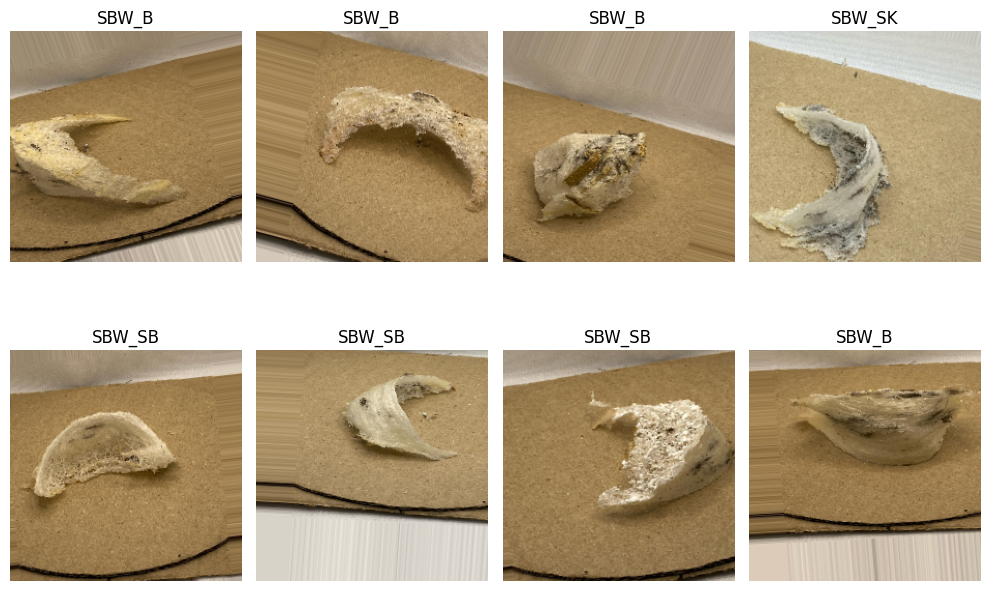

In [6]:
plt.figure(figsize=(10, 10))

# Mengambil batch pertama dari generator
images, labels = train_gen.next()  # Ubah train_generator menjadi train_gen

for i in range(8):  # Menampilkan 8 gambar
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])  # Menampilkan gambar
    label_idx = np.argmax(labels[i])  # Mendapatkan indeks label (untuk categorical)
    plt.title(categories[label_idx])  # Menampilkan nama kategori
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan lapisan-lapisan dari VGG16
vgg16_base.trainable = False

# Membangun model dengan menambahkan beberapa lapisan kustom
model = models.Sequential([
    vgg16_base,  # Menambahkan model VGG16 sebagai feature extractor
    layers.Flatten(),  # Meratakan output dari VGG16
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout untuk regularisasi
    layers.Dense(len(train_gen.class_indices), activation='softmax')  # Output layer dengan jumlah kelas
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size
)

Epoch 1/50
17/17 [==============================] - 374s 21s/step - loss: 1.5322 - accuracy: 0.3049 - val_loss: 1.1107 - val_accuracy: 0.5000
Epoch 2/50
17/17 [==============================] - 328s 19s/step - loss: 1.2594 - accuracy: 0.4545 - val_loss: 1.0108 - val_accuracy: 0.5437
Epoch 3/50
17/17 [==============================] - 367s 21s/step - loss: 1.1123 - accuracy: 0.4982 - val_loss: 0.8924 - val_accuracy: 0.6875
Epoch 4/50
17/17 [==============================] - 314s 18s/step - loss: 1.0105 - accuracy: 0.5720 - val_loss: 0.8513 - val_accuracy: 0.6625
Epoch 5/50
17/17 [==============================] - 285s 16s/step - loss: 0.9178 - accuracy: 0.6023 - val_loss: 0.7882 - val_accuracy: 0.6938
Epoch 6/50
17/17 [==============================] - 286s 16s/step - loss: 0.8787 - accuracy: 0.6042 - val_loss: 0.7524 - val_accuracy: 0.6938
Epoch 7/50
17/17 [==============================] - 319s 18s/step - loss: 0.8791 - accuracy: 0.6364 - val_loss: 1.0158 - val_accuracy: 0.5125
Epoch 

In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

3/3 [==============================] - 39s 7s/step - loss: 0.4640 - accuracy: 0.7625
Test Accuracy: 0.7625


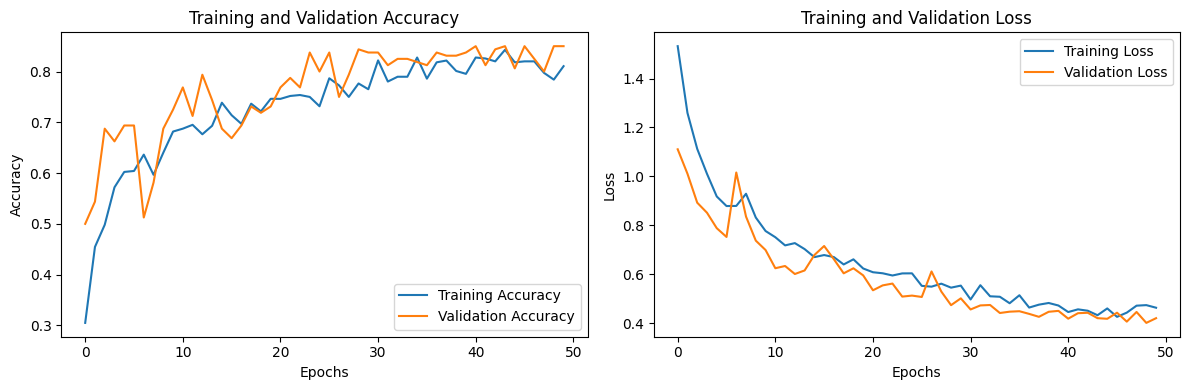

In [11]:
plt.figure(figsize=(12, 4))
# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:


# ImageDataGenerator untuk data uji (hanya rescale, tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator untuk test set
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # penting untuk evaluasi agar urutan label tetap
)

# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Prediksi gambar uji
pred_probs = model.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Contoh prediksi pertama
print("\nContoh prediksi:")
for i in range(80):
    true_label = class_labels[true_classes[i]]
    pred_label = class_labels[pred_classes[i]]
    print(f"Gambar ke-{i+1}: Benar = {true_label}, Prediksi = {pred_label}")


Found 80 images belonging to 4 classes.
3/3 [==============================] - 40s 8s/step - loss: 0.4640 - accuracy: 0.7625

Test Accuracy: 0.76
Test Loss: 0.46
3/3 [==============================] - 38s 7s/step

Contoh prediksi:
Gambar ke-1: Benar = SBW_B, Prediksi = SBW_SB
Gambar ke-2: Benar = SBW_B, Prediksi = SBW_SB
Gambar ke-3: Benar = SBW_B, Prediksi = SBW_SB
Gambar ke-4: Benar = SBW_B, Prediksi = SBW_K
Gambar ke-5: Benar = SBW_B, Prediksi = SBW_SB
Gambar ke-6: Benar = SBW_B, Prediksi = SBW_B
Gambar ke-7: Benar = SBW_B, Prediksi = SBW_SB
Gambar ke-8: Benar = SBW_B, Prediksi = SBW_B
Gambar ke-9: Benar = SBW_B, Prediksi = SBW_B
Gambar ke-10: Benar = SBW_B, Prediksi = SBW_K
Gambar ke-11: Benar = SBW_B, Prediksi = SBW_B
Gambar ke-12: Benar = SBW_B, Prediksi = SBW_B
Gambar ke-13: Benar = SBW_B, Prediksi = SBW_SB
Gambar ke-14: Benar = SBW_B, Prediksi = SBW_B
Gambar ke-15: Benar = SBW_B, Prediksi = SBW_SB
Gambar ke-16: Benar = SBW_B, Prediksi = SBW_B
Gambar ke-17: Benar = SBW_B, Predik

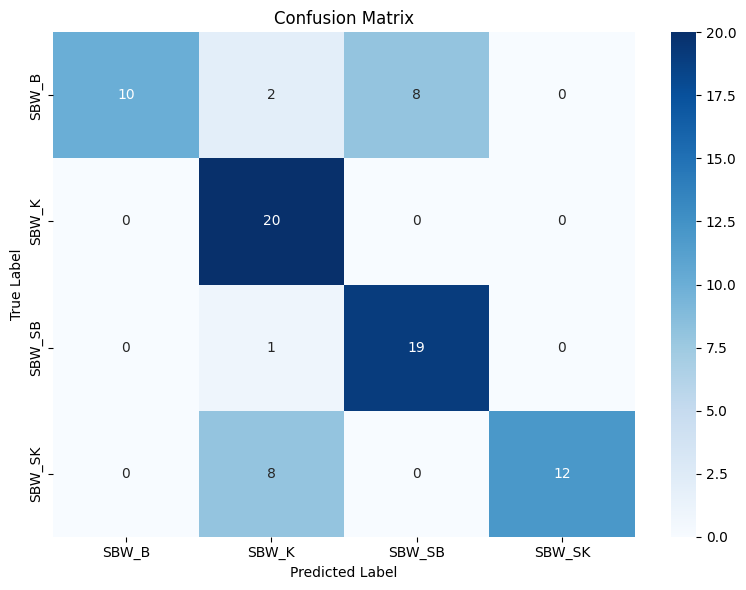


Classification Report:
              precision    recall  f1-score   support

       SBW_B       1.00      0.50      0.67        20
       SBW_K       0.65      1.00      0.78        20
      SBW_SB       0.70      0.95      0.81        20
      SBW_SK       1.00      0.60      0.75        20

    accuracy                           0.76        80
   macro avg       0.84      0.76      0.75        80
weighted avg       0.84      0.76      0.75        80



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Buat confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
class_labels = list(test_gen.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Tambahan: Classification report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))